In [2]:
# HOME
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
# use seaborn plotting defaults
import seaborn as sns; sns.set()

# get the code
import sys
sys.path.append('../codeCNV')
from plot import plot_snp, plot_2d, plot_3d
from rollingCNV import apply_rolling_SNP

home = '/Users/mahtin'
home = '/Users/martinscience'
# standard paths
testdata = os.path.join(home,"Dropbox/Icke/Work/somVar/testdata")
static_path = os.path.join(home, "Dropbox/Icke/Work/static")
cluster_path = os.path.join(home, "mount")
tooldata = os.path.join(home, "Dropbox/Icke/Work/somVar/tooldata")

# load the config
# edit config directly in yaml file
import yaml
config_file = '../config/config_devel.yaml'
def get_config(config_file):
        with open(config_file) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
            config = yaml.load(file, Loader=yaml.FullLoader)['CNV']['combine']
        return config
config = get_config(config_file)


cnvdata = os.path.join(tooldata, "myCNVdata")
output_path = os.path.join(cnvdata, "output")

# the path to the input data
cnv_path = os.path.join(cnvdata, "cnv")
cnvPON_path = cnv_path = os.path.join(cnvdata, "chromCov")
cnv_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/cnv")
cnvPON_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/chromCov")

## get the SNP data with FullExonPos

In [3]:
sample = "02_B"
snp_df = pd.read_csv(os.path.join(output_path, f'tmp/{sample}.snpcov.csv'), sep='\t')
snp_df

,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,log2ratiomeanDiff,Depth,EBscore,VAF
0,chr1,14930,836,836,1.327717,0.207271,0.0,38.0,0.799,0.105263
1,chr1,14933,839,839,1.337434,0.207271,0.0,39.0,1.239,0.076923
2,chr1,15759,930,930,0.691538,0.207271,0.0,16.0,0.545,0.062500
3,chr1,16949,1410,1410,1.294736,0.207271,0.0,258.0,0.685,0.286822
4,chr1,17384,1708,1708,0.618725,0.207271,0.0,292.0,0.402,0.003425
...,...,...,...,...,...,...,...,...,...,...
736744,chrX,156025116,49470062,1835599,-1.048722,-0.358225,0.0,134.0,1.106,0.522388
736745,chrX,156025122,49470068,1835605,-1.048584,-0.358641,0.0,138.0,0.384,0.007246
736746,chrX,156025182,49470128,1835665,-0.994248,-0.362291,0.0,143.0,0.508,0.006993
736747,chrX,156025194,49470140,1835677,-0.974114,-0.362933,0.0,140.0,0.641,0.007143


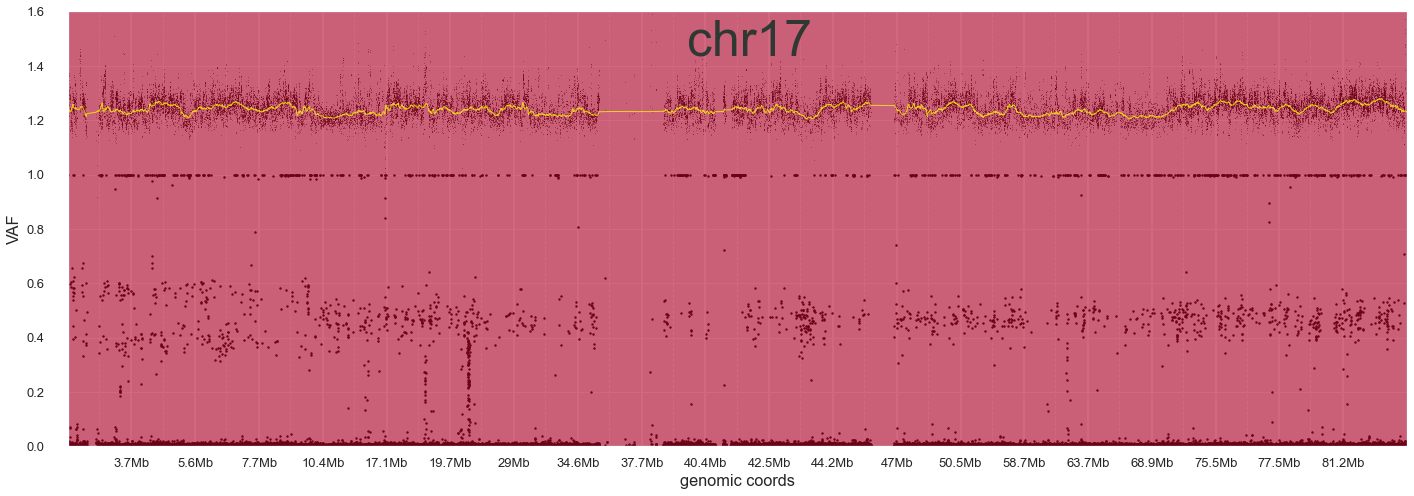

In [4]:
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.2,
            alpha=.7
        )
    )

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

vaf = dict(
        title='VAF',
        plot_type='scatter',  # ['line', 'scatter']
        data='VAF',
        plot_args=dict(
            s=2,
            color='black',
            alpha=1
        )
    )

fig_params = dict(
    figsize=(24,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(0,1),
    cov_offset=.1,  # how much log2ratio=0 is shifted above SNP-data
    cov_height=.5,
    label_size=13
)
chroms = ['chr5', 'chr7','chr8', 'chr11', 'chr17']
r1 = 'chr17:3Mb-9Mb'

fig, ax, df, chrom_df = plot_snp(snp_df.query('Chr == "chr17"'), snp_plots=[vaf], cov_plots=[log2, log2mean], chroms='all', region='chr17', **fig_params)

### strategy for finding cluster
+ look at one chrom
+ get the mean from the middle range (0.4 < VAF < 0.6)
+ compute loglikelihood for samples
+ compute rolling sum 

In [5]:
# chrom only
df = snp_df.query('Chr == "chr17"')
df

,Chr,Pos,FullExonPos,ExonPos,log2ratio,log2ratiomean,log2ratiomeanDiff,Depth,EBscore,VAF
285851,chr17,172420,18923009,2142,0.520562,-0.012694,0.0,85.0,1.602,1.000000
285852,chr17,172528,18923117,2250,0.381473,-0.012694,0.0,218.0,0.180,0.004587
285853,chr17,172529,18923118,2251,0.381920,-0.012694,0.0,216.0,0.411,0.004630
285854,chr17,172603,18923192,2325,0.461829,-0.012694,0.0,186.0,0.562,0.005376
285855,chr17,181151,18923311,2444,2.400767,-0.012694,0.0,57.0,0.199,0.017544
...,...,...,...,...,...,...,...,...,...,...
332076,chr17,83051767,21851879,2931012,-0.184641,-0.092046,0.0,54.0,0.595,0.018519
332077,chr17,83085072,21852185,2931318,1.943057,-0.092046,0.0,165.0,0.413,0.006061
332078,chr17,83085112,21852225,2931358,1.671491,-0.092046,0.0,228.0,0.419,0.004386
332079,chr17,83085116,21852229,2931362,1.669732,-0.092046,0.0,237.0,0.268,0.004219


/Users/martinscience/miniconda/envs/PDS-env/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/martinscience/miniconda/envs/PDS-env/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


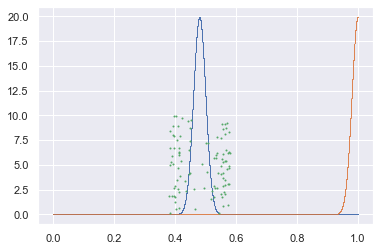

In [6]:
import numpy.random as rnd

sigma = 0.02
# get the mean of the center band
mean = df.query('0.4 < VAF < 0.6')['VAF'].mean()
mean

df2 = df.query('@mean - 0.1 < VAF < @mean + 0.1')
def llh(data, mean, sigma):
    s = np.sqrt(2 * np.pi) * sigma
    return np.exp((data - mean)**2 / (-2*(sigma**2))) / s
r = np.linspace(0,1,1000000)
plt.scatter(r, llh(r, mean, sigma), s=.01, alpha=0.1);
plt.scatter(r, llh(r, 1, 0.02), s=.01, alpha=0.1);
plt.scatter(df2.iloc[:100,:]['VAF'], rnd.random(100)*10, s=1)
df2.loc[:, 'llh'] = llh(df2['VAF'], mean, sigma)


df2.loc[:, 'LLH'] = df2['llh'].rolling(50).sum()
df2.loc[:, 'LLH'] = df2['LLH'] / df2['LLH'].max()
df2.loc[:, 'absVAF'] = np.abs(df2['VAF'] - mean) * 2

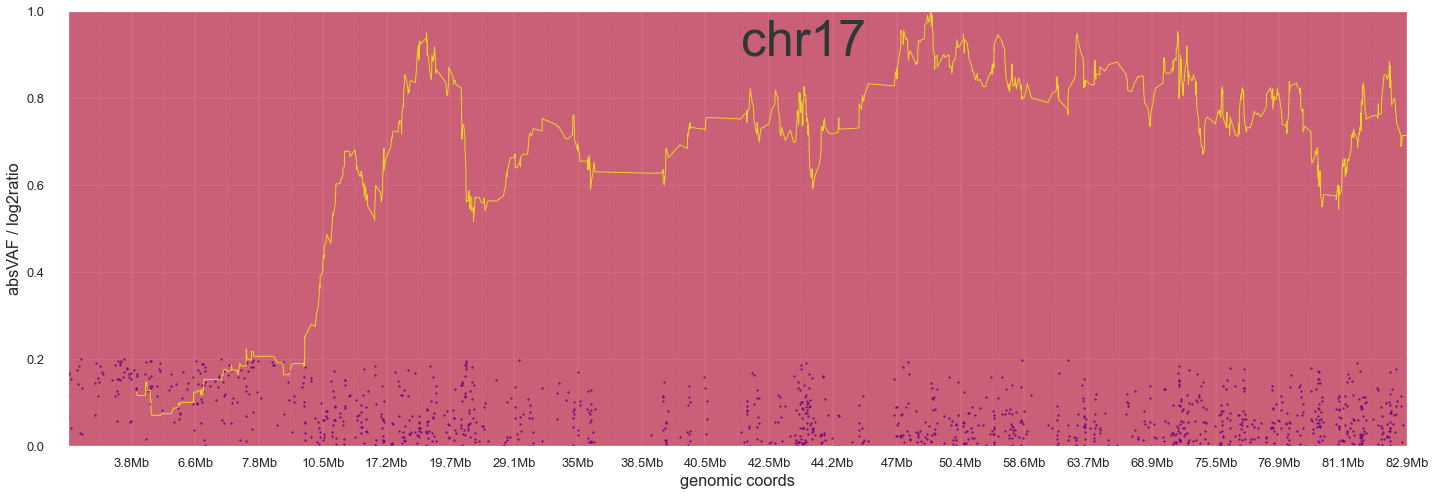

In [7]:
absvaf = dict(
        title='absVAF',
        plot_type='scatter',  # ['line', 'scatter']
        data='absVAF',
        plot_args=dict(
            s=2,
            color='blue',
            alpha=.7
        )
    )


LLH = dict(
        title='log2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='LLH',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

_ = plot_snp(df2, snp_plots=[absvaf, LLH], chroms='all', region='', **fig_params)

In [ ]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import silhouette_score as ssc

xcol = 'VAF'
ycol = "log2ratiomean"
df = snp_df.query('Chr == "chr17" and VAF > 0.02').iloc[:500,:]
select_cols = ['VAF']
X = df[select_cols]

model = GMM(n_components=4, covariance_type='diag', n_init=20).fit(X)
labels = model.predict(X)
fig, ax = plt.subplots()

_ = ax.scatter(df[xcol], df[ycol], c=labels, s=1, cmap='rainbow')
_ = ax.set_xlabel(xcol, fontsize=10)
_ = ax.set_ylabel(ycol, fontsize=10)
ssc(X, labels, metric='euclidean')

In [ ]:
model.means_

In [ ]:
model.covariances_